In [1]:
import synotil;reload(synotil)
import synotil.util as sutil; reload(sutil)
import pymisca.util as pyutil; reload(pyutil)
import pymisca.vis_util as pyvis; reload(pyvis)
# reload(sutil.ctMat)
pd = pyutil.pd; np = pyutil.np; plt=pyutil.plt
%matplotlib inline

sfile = '/home/feng/envs/pipeline_Bd/bin/config_Bd21-3.sh'
pyutil.envSource(sfile,silent=1);

is in ipython: 1
[WARN] pymisca.vis_util cannot find network
[WARN] Cannot find file:key.gene
[WARN] Cannot find file:key.gene
is in ipython: 1
[WARN] pymisca.vis_util cannot find network


In [262]:
# rnaseq = sutil.countMatrix.from_npy('../../bulkrna/Clust/round2/Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=75_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy')
fname = 'Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=0_norm=identityNorm_genre=DPGMM_nClu=25_maxIt=1000.npy'
rnaseq = scount.countMatrix.from_npy(fname)

In [3]:
# INDIR= '~/syno3/'
fnames = ['/media/pw_synology3/PW_HiSeq_data/ChIP-seq/Mapped_data/164C/Bd/Bd-ELF3-FLAG_S19/Bd-ELF3-FLAG_S19_raw_bowtie2_BD31_PE_sorted_rmdup_picard_genomenorm.bw',
 '/media/pw_synology3/PW_HiSeq_data/ChIP-seq/Mapped_data/164C/Bd/INPUT_141004_I317_FCC5EULACXX_L2_AR007/INPUT_141004_I317_FCC5EULACXX_L2_AR007_raw_bowtie2_PE_sorted_rmdup_picard_genomenorm.bw']

# fnames = find /media

In [201]:
%%time
chipseq = sutil.extractBigWig(fnames[0],bedFile='./Bdistachyon_314_v3.1.gene_exons.gtf.cds.promoter',stepSize = 50)
chipseq = sutil.countMatrix.from_DataFrame(chipseq,)
chipseq.sanitiseIndex(synotil.ptn.BdAcc)
chipobs = chipseq


AttributeError: type object 'countMatrix' has no attribute 'from_DFrame'

In [ ]:
chipobs

 [WARN] Cannot find file:key.gene
[WARN] pymisca.vis_util cannot find network


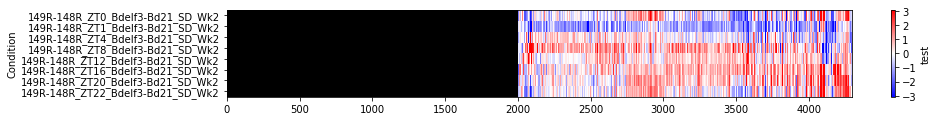

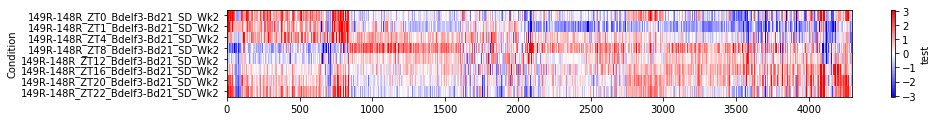

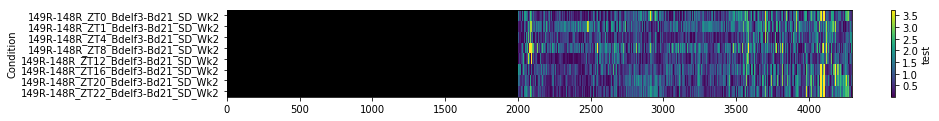

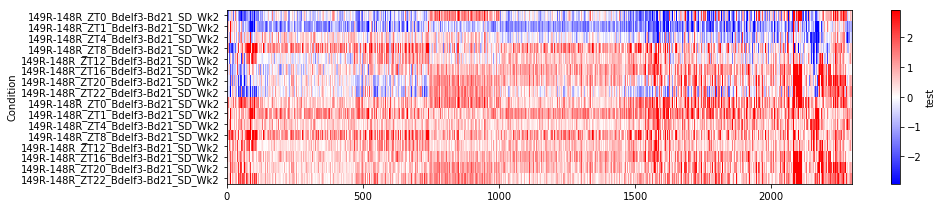

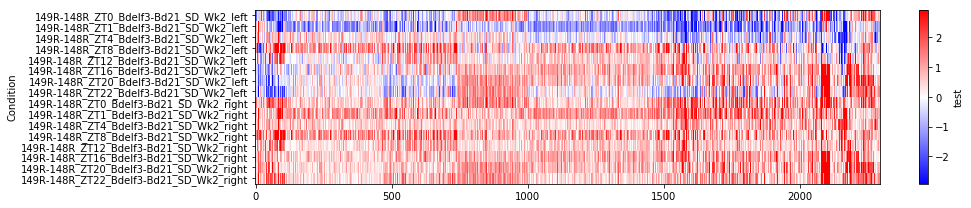

In [365]:
reload(sutil)
import synotil.countMatrix as scount
reload(scount)
reload(pyvis)
tests = {
#     lambda x: sutil.countMatrix.from_DataFrame(fname=x):'../../bulkrna/MatPrep/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk',
    scount.countMatrix.from_npy:'./Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=0_norm=identityNorm_genre=DPGMM_nClu=25_maxIt=1000.npy',
           }

for f,v in tests.items():
    dd = f(v)


import synotil.countMatrix as scount
reload(scount)
d0 = dd.copy()
# dd = scount.countMatrix(chipseq.df.values,rowName=chipseq.df.index,colName=chipseq.df.columns)
dcopy = dd.copy()
dd.colName_short()

dd.iloc[:2000,:] = np.nan
dd.heatmap()

dfix = dd.fillna(dcopy,inplace=0)
dfix.heatmap()

dd = dd.apply(abs,)
dd.heatmap()

# d2 = dfix.merge(dd)
dd = dd.setDF(dd.loc[~dd.iloc[:,0].isnull()])
d2 = scount.concat([dfix,dd],axis=1, join='inner')
d2.heatmap()

d2 = dfix.mergeByIndex(dd,how='right')
d2.heatmap()

# dd.heatmap(dd.apply(abs))


In [211]:
%time d3 = scount.vstack([d0,dd,dfix]*25,how='inner',as_index=0)
%time d3d = scount.vstack([d0,dd,dfix]*25,how='inner',as_index=1)


CPU times: user 1.05 s, sys: 52 ms, total: 1.1 s
Wall time: 1.1 s
CPU times: user 608 ms, sys: 8 ms, total: 616 ms
Wall time: 614 ms


In [277]:
# rnaseq.sortedLabel()
# rnaseq.sortedLabel
rnaclu.dtypes[0] == 'int'

True

In [ ]:
pyutil.mpl.cm.Set1

In [308]:
type(plt.cm.autumn)

matplotlib.colors.LinearSegmentedColormap

In [345]:
?df.reindex

In [705]:
??pyvis.discrete_cmap

In [829]:
ax.yaxis.tick_right?

In [ ]:
ax

In [203]:
%%writefile ~/repos/BrachyPhoton/synotil/PanelPlot.py
# reload(scount)

import CountMatrix
from CountMatrix import *
import pymisca.vis_util as pyvis; reload(pyvis)
import pymisca.util as pyutil; reload(pyutil)
plt = pyvis.plt
import textwrap
import xlsxwriter
# reload(pyutil)
# pyutil.cluMap = pyutil.mpl.colors.ListedColormap(['r', 'g', 'b', 'y', 'w', 'k', 'm'])


def guessLook(obj):
    '''Guess how DataFrame should be plotted from its shape
'''
    look = 'patch'
    if obj.shape[-1] > 1:
        look = 'matrix'
    else:                
        dtype = obj.dtypes.iloc[0] 
        if dtype == 'int':
            look = 'patch'
        else:
            look = 'line'
    obj.look = look
    return look
import copy
def fixCluster(ele):
    ''' Fix a integer-type track into a color track
'''
    val = ele.fillna(0).values
    N = val.max() - val.min() + 1 
    if N==2:
        shuffle = 0
    else:
        shuffle = 1
    cmap = pyvis.discrete_cmap(N,'Spectral',shuffle = shuffle,seed=0)
    cmap.set_bad('black',1.)
    C = ele.values; 
#                     print C.shape
    C = np.ma.array ( C, mask=np.isnan(C))
#                     print C.shape
    cmat = cmap( C ).squeeze()
#     print cmat.shape
#     ele  =pd.DataFrame(cmat).set_index( ele.index)
#     ele.look = 'patch'
    elenew = ele.setDF(pd.DataFrame(cmat).set_index( ele.index) )
    elenew['clu'] = ele.values; ele =elenew
    ele.cmap = cmap
    ele.look = 'patch'
    return ele

# from matplotlib.ticker import NullFormatter

hide_axis = pyvis.hide_axis
hide_frame= pyvis.hide_frame

# ax.xaxis.set_major_formatter(NullFormatter())

class panelPlot(list):
    '''Class to systematically render plots
'''
    @property
    def shape(self):
        return [x.shape for x in self]
    
    def __init__(self,lst, validate= 1, 
                 _compiled = False, 
                 orig = None,
                 index =None,
                 geneName = None,
                 names  =None,
                 figsize = None,
                 *args,**kwargs):
        first = list(lst[0])
        if isinstance(first[0],str):
            if len(first) == 2:
                names, lst = zip(*lst)
        super(panelPlot, self).__init__(lst)
        self.set_names(names)
#         for x in self:
#             x.cmap = None
        self.index = None
        self.validate() if validate else None
        self._compiled = _compiled
        self.orig = orig
        self.index = index
        self.geneName = geneName 
        self.DIR = '.'
        self.fig = {}
        self.figsize = figsize
    def __getslice__(self, *args):
        '''To be extended to allow for easier subIndex
'''
        dct = self.__dict__
        self.__init__(
            super(panelPlot, self).__getslice__(*args),
            **dct)
        return self
    def setAttr(self,**kwargs):
        for k,v in kwargs.items():
            setattr(self,k,v)
        return self
        
    def validate(self,):
        for x in self:
            pass
#             assert hasattr(x,'render'),'element "%s" does not support render()' % x.__repr__()
        return True
    
    def _render(self, obj, axs= None, look = 'patch',  figsize=[14,6],
                shortName=1,**kwargs):
        '''[CORE]: Contains rendering methods for different types of data
'''
        if axs is None:
            fig, axs = plt.subplots(1,1,figsize=figsize,sharex='all')
#             ax = axs
            ax =axs
        else:
            ax = axs[1]
        assert isinstance(obj, CountMatrix.countMatrix)
        axa,axb,axc = axs
        axa.get_shared_y_axes().join(axa, axb)

        hide_axis(axa); 
        hide_frame(axc);hide_axis(axc); 
        
        vlim = obj.vlim
        if look =='matrix':
            res = obj.heatmap(ax=axb,cname = None)   
#             axs[0].fig
            plt.colorbar(mappable=res, cax = axc )
            axcy = axc.get_yaxis(); axcy.tick_right(); axcy.set_visible(True)
#             axb.set_ylabel('')
        elif look =='patch':
            df = obj.fillna(0); df[3] = 1
            res = pyvis.heatmap(
                df.values[None,:,:3],
                ax=axb,
                cname=None,
#                 vlim = [None,None],
#                 vlim = [0,1]
            )           
        elif look =='line':
            res = axb.plot(obj.values, 'x')
            if vlim is not None:
                axb.set_ylim(vlim)
            
        axb.set_xlim(0-0.5,len(obj)-0.5)
        axb.grid(color='black',axis='x',linestyle='--')
        axb.set_xticks(np.linspace(0,len(obj),20+1))
        axb.set_ylabel('')
        hide_axis(axb);
        



        #### Add row label within each track
        colnames = obj.colName_short() if shortName else obj.columns
#         colnames = obj.columns
        for i,col in enumerate(colnames):
            axa.text(1., i,
                 str(col)[:20],
                 horizontalalignment='right',
                  verticalalignment='center',
                  clip_on=True
                )
        
        ### Add track name
        trackName = pyutil.formatName(obj.name)
        axa.text(-.0, sum(axa.get_ylim())/2.,
                 trackName,
                 horizontalalignment='right',
                  verticalalignment='center',                 
                )            
        axa.yaxis.set_visible(True);axa.yaxis.set_ticks([])
        
        return axs
    def namedIndex(self,index=None,geneName = None):
        index = self.index if index is None else index
        geneName = self.geneName if geneName is None else geneName
        if geneName is None:
            ind = list(index)
        else:
            assert isinstance(geneName,pd.DataFrame)
            res = geneName.reindex(index=index)
            ser = res.iloc[:,0]
            nidx = ser.isnull()
            ser[nidx] = ser.index[nidx]
            ind = list(ser)
#             res.loc[nidx, res.columns[0]] = res.index[nidx]
#             ind = res.iloc[:,0]
        return ind
            
        
    def autoFigsize(self):
        xsize = min(len(self.index)*0.25, 14)
        ysize = (len(self) + 1 )*1.5
        return [xsize,ysize]
        
    def render(self,  figsize= None,
              index=None, how = 'outer', order = None,
               shortName=1,
              silent= 1):
        
        if not self._compiled:
            self.compile(how = how,index = index, order =order)
        else:
            self.joinIndex(how=how) if how is not None else None
            self.orderBy(order=order) if order is not None else None
            
        figsize = figsize or self.figsize or self.autoFigsize()

        fig,axsLst = plt.subplots(len(self),3,figsize=figsize,sharex='col',
#                                   frameon = False,
                                  gridspec_kw={'width_ratios':[1, 8, .15],
                                               'wspace':0.05
                                              })
        if len(self)==1:
            axsLst = axsLst[None,:]
#         if not isinstance(axsLst,pyutil.np.ndarray) else axsLst
        
#         plt.suptitle(title,y=0.95)     
        for i in range(len(self)):
            axs, ele = axsLst[i], self[i]            
#             ax = axs[1]
            self._render(ele, axs=axs, look = ele.look,silent = silent,
                        shortName=shortName)
        title = 'N=%d'%len(ele); 
        axsLst[0][1].set_title(title)
        
        if self.index.__len__()<=100:
            xticks = self.namedIndex()
            ax = axsLst[-1][1]; plt.sca(ax)
#             ax.xaxis.set_major_formatter(mticker.FixedFormatter())
            plt.xticks(range(len(xticks)),xticks, rotation = 'vertical')
        self.fig['handle'] = fig
        return fig 
    def cache(self, cacheName = 'test', fig= None):
        fig = self.fig.get('handle',None) if fig is None else fig
        assert fig is not None
        if self.DIR == './':
            print '[WARN] self.DIR is defaulting to current directory'
        figName = '%s/src/%s.png'%(self.DIR,cacheName)
        self.check_DIR( pyutil.os.path.dirname(figName) )
        figMd = pyutil.showsavefig(fig= fig,fname=figName)
        self.fig['name'], self.fig['md'] = figName,figMd
        return (figName, figMd)
    def copy(self,deep = False):
        new = copy.copy(self)
        return new
    def compile(self,
                index = None, how = 'outer', order = None,
               silent=1):
        '''
index: Specify the data to be included. Inferred from joinIndex() if is None
    how: passed to joinIndex()
    order: passed to joinIndex()
'''
        if self.orig is None:
            self.orig = self.copy()
#         self.joinIndex(how=how) if how is not None else None
        if index is None:
            self.index = self.index if self.index is not None else self.joinIndex(how=how, )
        else:
            self.index = index            
        self.orderBy(order=order) if order is not None else None        
            
        looks = [guessLook(ele) if not ele.look else ele.look for ele in self ]
        
        for i, ele in enumerate(self):
            if not silent:
                print 'Index:%d'% i,
                print 'look:', ele.look, len(ele)
            ele = ele.setDF(ele.reindex( self.index ))
            if looks[i] == 'patch':
                if ele.cmap is None:
                    ele = fixCluster(ele)
            self[i] =  ele
        
        self._compiled = True
        return self
    def recompile(self,*args,**kwargs):
        orig = self.reset()
        orig.compile(*args,**kwargs)
        orig._compiled=False
        return orig
#         return {'index':index}
    
    def reset(self, orig =None):
        orig = orig or self.orig
        if orig is None and not self._compiled:
            print '[WARN] Trying to reset() a raw <panelPlot>'
            orig = self
        return orig
    
    def makeFirst(self,i=0):
        '''
Promote ith element to the starting of list
'''
        self.insert(0,self.pop(i))
        return self
    def joinIndex(self, how = None,):
        '''
order: A DataFrame which will be sorted to obatin the ordering      
'''
        if how is None:
            how = 'outer'
        idx = vstack(self,as_index = 1, how=how)
        self.index = idx
        return idx
    def orderBy(self, order = None, how=None ):
        if self.index is None:
            idx = self.joinIndex(how=how)
        else:
            idx = self.index
        if order is not None:
            df = order.reindex(idx)
            pyutil.reset_columns(df)
            df = df.sort_values(by=list(df.columns),axis=0)
            self.index = idx = df.index
        return idx
    def set_names(self,names):
        if names:
            it = iter(names)
            for i in range(len(self)):
                name = next(it,None)
                if name:
                    self[i].set_name( name)
        return self
    @property
    def bigTable(self,how = 'outer'):
        lst = [x.copy() for x in self]
        types = pyutil.flatSubset([x.name for x in self],keep='type')
        for i,dd in enumerate(lst):
#             print '[look]=',dd.look
            if dd.look =='patch':
#                 print '[A patch]'
                lst[i] = dd.setDF(dd[dd.columns[-1:]])
        for i,dd in enumerate(lst):
            if dd.name.find('type')!=-1:
                TYPE = pyutil.flatSubset([dd.name],keep='type')[0]
            else:
                TYPE = 'unknown'
            dd.columns = ['%s_%s'%(TYPE, col) for col in dd.columns]
        res = vstack(lst, how=how)
        return res
    def check_DIR(self,DIR = None):
        DIR = self.DIR if DIR is None else DIR
        pyutil.shellexec('mkdir -p %s'%DIR)
        return DIR
    def emptyExcel(self,fname ='main.xlsx'):
        ExcelFile= pd.ExcelWriter('%s/%s'%(self.DIR,fname), engine='xlsxwriter')
        return ExcelFile
    def dump(self, ExcelFile = 'main.xlsx', sheetName = 'test',figName = None,
             saveClose = 1,
            ):
        figName = figName or self.fig.get('name', None) 
        self.check_DIR()
        if isinstance(ExcelFile, str):
            ExcelFile = self.emptyExcel(ExcelFile)
        self.bigTable.to_excel( ExcelFile, sheetName,index=True,)
        sheet_curr = ExcelFile.sheets[sheetName]
        if figName is not None:
            sheet_curr.insert_image(0, 7, figName)
        if saveClose:
            ExcelFile.save()
            ExcelFile.close()
        return ExcelFile
    
class geneList(countMatrix):
    def __init__(self,C=None,colName=None,rowName=None,**kwargs):
        super(geneList,self).__init__(C=len(rowName) * [1],rowName=rowName, **kwargs)
        self.astype('int')
        

def renderByCluster(panel,clu,DIR = None, addClu = 0,ExcelFile = None):
    assert isinstance(panel,panelPlot)
    assert isinstance(clu, CountMatrix.countMatrix)
#     if panel._compiled:
#         panel = panel.reset()
#     if clu not in panel:
    clu = clu.reindex(panel.index)
    if addClu:
        assert 0,"addClu=1 is buggy"
        fixClu = fixCluster(clu)
        fixClu.set_name( 'type=cluster_%s'%fixClu.name)
        panel.append(fixClu)
    if DIR is not None:
        panel.check_DIR(DIR)
        panel.DIR = DIR
    if ExcelFile is not None:
        if isinstance(ExcelFile,str):
            if not ExcelFile.endswith('.xlsx'):
                ExcelFile = ExcelFile +'.xlsx'
            ExcelFile = panel.emptyExcel(ExcelFile) 
        else:
            pass
    it = pyutil.itertools.chain( [(-1, panel)], clu.groupby( clu.columns[0], ) )
    for ci, df in it:
#         print ci
        pp = panel.copy()
        print pp
#         print 'cmap',pp[-1].cmap
        pp.index = df.index
        pp.compile(index = df.index)
        pp.render()
        if ExcelFile is not None:
            sheetName =  'clu%03d'%ci
            pp.cache(sheetName)
            ExcelFile = pp.dump(ExcelFile = ExcelFile,sheetName = sheetName, saveClose=0)
    ExcelFile.save(); ExcelFile.close();
panelPlot.renderByCluster = renderByCluster
#         pp.bigTable()
#         plt.show()


Overwriting /home/feng/repos/BrachyPhoton/synotil/PanelPlot.py


In [196]:
!chmod 777 -R /home/feng/repos/BrachyPhoton/

In [188]:
reload(pyutil)
import synotil.CountMatrix as scount
scount.countMatrix.colName_short??

is in ipython: 1


In [127]:
# import openpyxl
# ws = openpyxl.load_workbook('main.xlsx')
# st = ws.worksheets[0]
# st.add_image(openpyxl.drawing.image.Image('./src/test.png'), 'A1')
# # ws.save?
# ws.save('main.xlsx')

In [123]:
# improt 
xlsxwriter.xmlwriter

In [105]:
import pymisca.util as pyutil
pyutil.showsavefig?

In [117]:
?pyutil.pd.ExcelWriter

In [ ]:
def dump(self,fname = None, sheetName = 'test',fig = fig):
    ExcelFile= pd.ExcelWriter('%s/main.xlsx'%self.DIR, engine='xlsxwriter')
            sheet_curr = ExcelFile.sheets[cluName]
    FFname = 'src/clu%03d.png'%(clu,)
    if fig is not None:
        FigMd = pyutil.showsavefig(fig= fig,fname=FFname)
            sheet_curr.insert_image(0, 7, FFname)

            gCur[['Gene Name']].to_csv('src/%s'%cluName,index=0,)
            dd.df.loc[gCur['Gene Name']].to_excel(ExcelFile,cluName,index=True,)                
    ExcelFile.save()
    ExcelFile.close()

In [107]:
import synotil

fname = '../PAIRWISE_COMPARE=NO_FC=1.0_QVALUE=0.05_TITLE=164C_36C_PVALUE=0.05/summary/Bd-ELF3-FLAG_S19_gene_list.txt'
df = geneList.from_DataFrame(fname = fname,ext='tsv')
chipPeak = df
        
# rnaseq = sutil.countMatrix.from_npy('../../bulkrna/Clust/round2/Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=75_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy')
fname = 'Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=0_norm=identityNorm_genre=DPGMM_nClu=25_maxIt=1000.npy'
rnaseq = scount.countMatrix.from_npy(fname)
rnaclu = rnaseq.sortedLabel().sort_values(0)

dd = rnaseq
a = panelPlot([
               rnaclu,
               chipPeak,
               dd.setDF(dd.iloc[:10000]),
               dd.setDF(dd.iloc[:,0:1]),
#                rnaclu.astype('float'),
              ])
print a.shape
# a.render()
# a.makeFirst(1)
# .render()
# a.calc_index()
# a.render(how='left',index = rnaclu.index, )
a.compile(how='left',
         order = vstack([chipPeak,rnaclu])
        )
# a.render()
# a.reset()
index0 = a.index
a.compile(index = a.index[:400])
a.render()

a.compile(index = a.index[:100])
a.render()

a = a.recompile(index=index0)
a.render()

NameError: name 'geneList' is not defined

In [794]:
ax.set_ylabel?

In [726]:
np.isnan(rnaclu_fixed.reindex(a.index).fillna(1).values).mean()

0.0

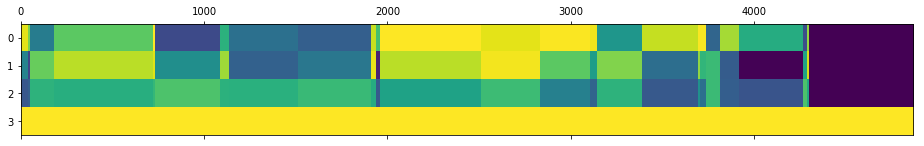

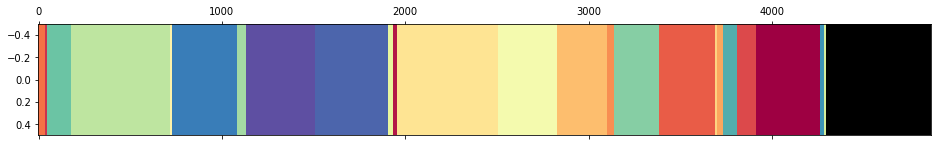

In [737]:
df = rnaclu_fixed.reindex(a.index).fillna(0)
df[3] = 1
plt.matshow(df.values[:].T,aspect='auto')
plt.matshow(df.values[None,:], aspect='auto')

In [753]:
rnaclu.cmap

Index([u'Bradi4g23475', u'Bradi1g03605', u'Bradi2g13084', u'Bradi2g13083',
       u'Bradi3g16293', u'Bradi1g39217', u'Bradi1g39211', u'Bradi1g39209',
       u'Bradi1g39196', u'Bradi1g39195',
       ...
       u'Bradi5g20171', u'Bradi5g23651', u'Bradi5g23656', u'Bradi5g23660',
       u'Bradi5g24412', u'Bradi5g24820', u'Bradi5g25284', u'Bradi5g25291',
       u'Bradi5g25500', u'Bradi5g26520'],
      dtype='object', length=4870)


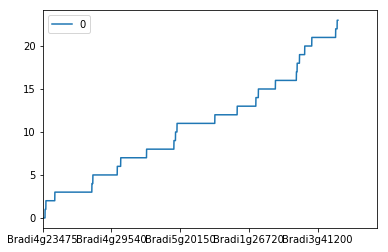

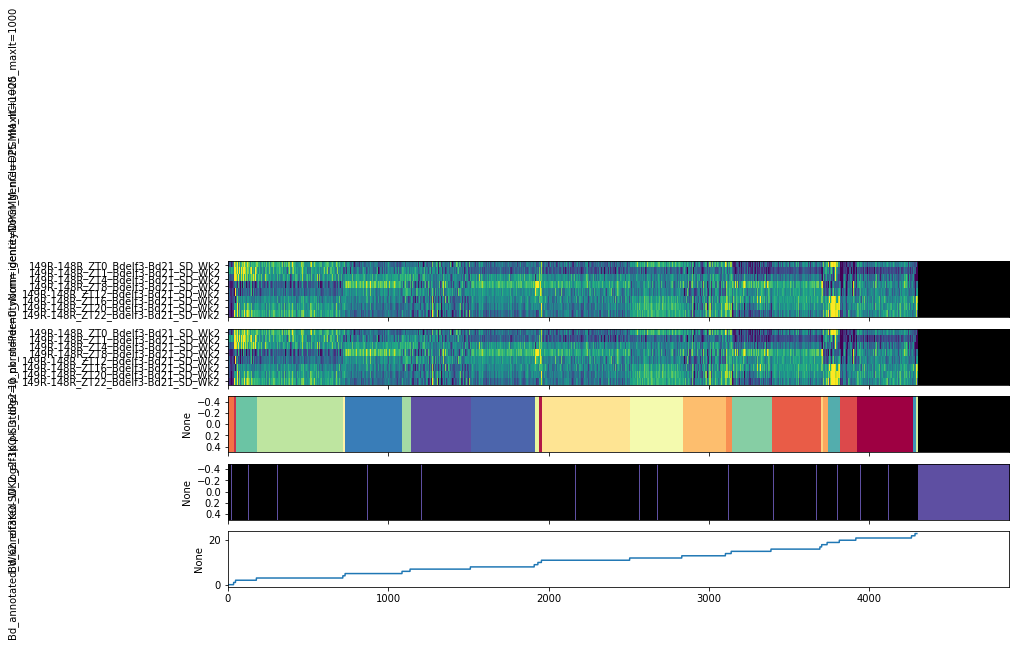

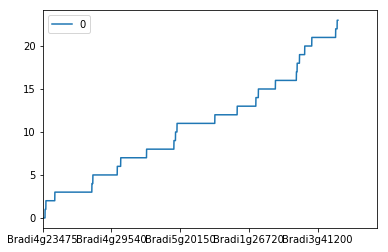

In [788]:
rnaclu_fixed = fixCluster(rnaclu)
# rnaclu_fixed = (rnaclu)
a = panelPlot([
    rnaseq,
               dd.setDF(dd.iloc[:10000]),
#                dd.setDF(dd.iloc[:,0:1]),
               rnaclu_fixed,
               chipPeak,
               rnaclu.astype('float'),
              ])

a.orderBy(order = rnaclu.fillna(0),how='outer')

# plt.matshow(rnaclu_fixed.reindex(a.index).fillna(1).values[None,:],aspect='auto')
print a.index

# rnaclu.loc[a.index].plot()
# a.compile(index = rnaclu.index)
rnaclu.loc[a.index].plot()
# a[1].loc[a.index].plot()
# a[1] = fixCluster(rnaclu)
a.render()

rnaclu.loc[a.index].plot()

# a = a.reset()
# a.compile()
# a.render()


In [67]:

def renderByCluster(panel,clu,addClu=1):
    assert isinstance(panel,panelPlot)
    assert isinstance(clu, countMatrix)
    if panel._compiled:
        panel = panel.reset()
#     if clu not in panel:
#     if not any([fixClu is x for x in panel]):
    if addClu:
        fixClu = fixCluster(clu)
        panel.append(fixClu)
    panel = panel.copy().compile(order=clu)
    panel.render()
    for ci, df in clu.groupby(clu.columns[0]):
#         print ci
        pp = panel.copy()
#         print 'cmap',pp[-1].cmap
        pp.index = df.index
        pp.compile(index = df.index)
        pp.render()

#         if ci ==5:
#             break

dfc =  rnaclu_fixed.copy()
dfc.look = 'matrix'
a = panelPlot([
               dd.setDF(dd.iloc[:10000]),
#                dd.setDF(dd.iloc[:,0:1]),
#                rnaclu_fixed,
#             rnaclu,
#                dfc,
               chipPeak,
#                rnaclu.astype('float'),
              ])
a0 = a
a0.orderBy(order=rnaclu)
# a0.compile(order=)
a0.render()
# a0.compile(index=a0.index[:1000])
# a0.render()
renderByCluster(a0.reset(),rnaclu)

NameError: name 'rnaclu_fixed' is not defined